In [51]:
import pandas as pd
import seaborn as sns
import re
from tqdm import tqdm
from geopy.geocoders import Nominatim

**DATOS**: http://datos.salud.gob.ar/dataset/defunciones-ocurridas-y-registradas-en-la-republica-argentina-en-el-ano-2017

In [52]:
datos : pd.DataFrame = pd.read_csv('defunciones.csv', encoding='ISO-8859-1')

/tmp/ipykernel_490/1327773562.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  datos : pd.DataFrame = pd.read_csv('defunciones.csv', encoding='ISO-8859-1')


In [53]:
datos.head()

,anio,jurisdiccion_de_residencia_id,jurisdicion_residencia_nombre,clasificacion,Sexo,muerte_materna_id,muerte_materna_clasificacion,grupo_edad,cantidad
0,2014,34,Formosa,Dificultad respiratoria del recién nacido,masculino,NaN,NaN,De a 0 a 14 anios,22
1,2007,22,Chaco,Otras gastroenteritis y colitis de origen infe...,masculino,NaN,NaN,01.De a 0 a 14 anios,1
2,2008,82,Santa Fe,"Neumonía viral, no clasificada en otra parte",masculino,NaN,NaN,01.De a 0 a 14 anios,1
3,2016,94,"Tierra del Fuego, Antártida e Islas del Atlánt...","Neumonía, organismo no especificado",masculino,NaN,NaN,01.De a 0 a 14 anios,1
4,2012,90,Tucumán,Otras alteraciones cerebrales del recién nacido,masculino,NaN,NaN,01.De a 0 a 14 anios,1


In [54]:
pattern : str = "(\d{1,}\s{1,}a\s{1,}\d{1,})"
def parse(exp: str) -> str:
    try:
        if exp == "05.De 75 anios y mas":
            return "75 a mas"
        match: str = re.findall(pattern=pattern, string=exp)[0]
        return match
    except:
        return "ND"

In [55]:
datos['grupo_edad'] = datos['grupo_edad'].apply(lambda x: parse(x))

In [56]:
len(datos)

778353

In [57]:
datos = datos[datos['grupo_edad'] != 'ND']
datos = datos[~datos['Sexo'].isin(['indeterminado', 'desconocido'])]

In [58]:
datos['grupo_edad'].unique()

array(['0  a 14', '15 a 34', '35 a 54', '55 a 74', '75 a mas'],
      dtype=object)

In [59]:
datos['Sexo'].unique()

array(['masculino', 'femenino'], dtype=object)

In [60]:
def clasificacion_parse(exp: str) -> str:
    exp = str(exp)
    
    enf : list = ['Meningitis bacteriana',
                  'Neumonía',
                  'Dificultad respiratoria',
                  'Fibrosis quística',
                  'Neumonitis',
                  'Parálisis cerebral',
                  'osteocondrodisplasias',
                  'Hemorragia intracraneal',
                  'Envenenamiento',
                  'INSUFICIENCIA HEPÁTICA',
                  'MALFORMACIONES CONGÉNITAS',
                  'vih',
                  'tumor maligno',
                  'Caída',
                  'tumor',
                  'Lesión autoinfligida',
                  'hemorragia',
                  'Envenenamiento autoinfligido',
                  'disparo',
                  'Alopecia',
                  'leuciemia',
                  'insuficiencia respiratoria',
                  'transtornos respiratorios',
                  'caída',
                  'negligencia']
    
    viales : list = ['Ciclista',
                     'vehículo',
                     'motociclista',
                     'colisión']
    
    for i in enf:
        i = i.upper()
        exp = exp.upper()
        
        if i in exp:
            return str(i).capitalize()
        
    for i in viales:
        i = i.upper()
        exp = exp.upper()
        
        if i in exp:
            return 'Siniestro vial'

    else:
        return exp.capitalize()

In [61]:
datos['clasificacion'] = datos['clasificacion'].apply(lambda x: clasificacion_parse(x))

In [ ]:
print(len(datos['clasificacion'].unique()))

1153


In [ ]:
len(datos)

765642

<Axes: xlabel='count'>

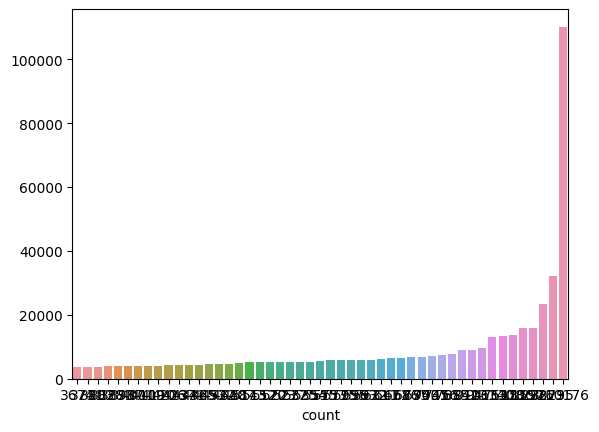

In [66]:
enfermedades_mas_comunes = datos['clasificacion'].value_counts().head(50)

sns.barplot(enfermedades_mas_comunes, x=enfermedades_mas_comunes.index, y=enfermedades_mas_comunes.values)

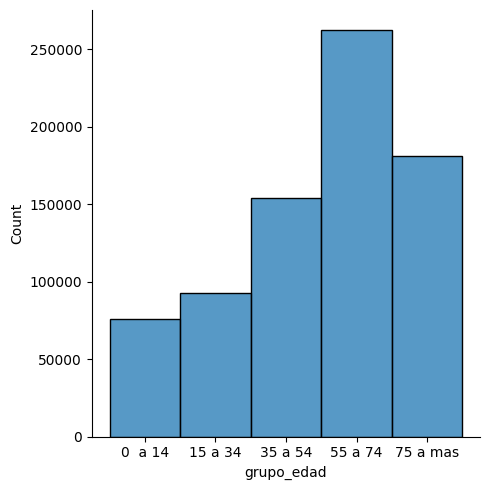

In [ ]:
sns.displot(datos['grupo_edad'])

In [67]:
enfermedades_mas_comunes = enfermedades_mas_comunes.index.tolist()
datos = datos[datos['clasificacion'].isin(enfermedades_mas_comunes)]

In [ ]:
len(datos)

469737

In [68]:
datos['jurisdicion_residencia_nombre'] = datos['jurisdicion_residencia_nombre'].apply(lambda x: f'{x}, Argentina')

In [71]:
datos = datos[datos['jurisdicion_residencia_nombre'] != 'Sin Información, Argentina']

In [72]:
geo_info : dict = {}

geolocator = Nominatim(user_agent="MyApp")

datos = datos[datos['jurisdicion_residencia_nombre'] != 'Sin Información']

with tqdm(total=len(datos['jurisdicion_residencia_nombre'].unique())) as pbar:
    for i in datos['jurisdicion_residencia_nombre'].unique().tolist():
        if i == 'Tierra del Fuego, Antártida e Islas del Atlántico Sur':
            i = 'Tierra del Fuego' 

        location = geolocator.geocode(i)
        
        if i == 'Tierra del Fuego':
            i = 'Tierra del Fuego, Antártida e Islas del Atlántico Sur' 
        
        geo_info[i] = [location.latitude, location.longitude]
        
        pbar.update()

100%|██████████| 25/25 [00:27<00:00,  1.08s/it]


In [73]:
latitudes: list = []
longitudes: list = []

with tqdm(total=len(datos['jurisdicion_residencia_nombre'].to_list())) as pbar:
    for i in datos['jurisdicion_residencia_nombre'].to_list():
        latitudes.append(geo_info[i][0])
        longitudes.append(geo_info[i][1])
        pbar.update()

  4%|▍         | 18275/464499 [00:00<00:02, 182745.38it/s]

100%|██████████| 464499/464499 [00:03<00:00, 146000.42it/s]


In [75]:
datos['latitud'] = latitudes
datos['longitud'] = longitudes

In [81]:
counts = datos['jurisdicion_residencia_nombre'].value_counts()

jurisdicion_residencia_nombre
Buenos Aires, Argentina                                             59089
Santa Fe, Argentina                                                 38136
Córdoba, Argentina                                                  33836
Ciudad Autónoma de Buenos Aires, Argentina                          31386
Mendoza, Argentina                                                  26439
Entre Ríos, Argentina                                               22064
Chaco, Argentina                                                    20827
Tucumán, Argentina                                                  20613
Salta, Argentina                                                    19762
Corrientes, Argentina                                               18917
San Juan, Argentina                                                 16307
Santiago del Estero, Argentina                                      15815
Misiones, Argentina                                                 15585
Río Negr

In [82]:
datos.to_csv('defunciones_argentina.csv')